# KNN Direct Marketing

## Load Packages

In [7]:
import pandas as pd
import numpy as np
import group3lib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns


## Import Data

In [11]:
df = pd.read_csv('Data/DirectMarketing_Cln_Classification.csv')

In [12]:
df.head()

,Salary,Children,Catalogs,Middle,Old,Young,Female,Male,Own,Rent,Married,Single,Close,Far,Amt_Spnt_Class
0,47500,0,6,0,1,0,1,0,1,0,0,1,0,1,Low
1,63600,0,6,1,0,0,0,1,0,1,0,1,1,0,Med
2,13500,0,18,0,0,1,1,0,0,1,0,1,1,0,Low
3,85600,1,18,1,0,0,0,1,1,0,1,0,1,0,High
4,68400,0,12,1,0,0,1,0,1,0,0,1,1,0,Med


## Clean Data

In [13]:
features = df.iloc[:,0:-1]
labels = df.iloc[:,-1]

#### Normalize Data

In [14]:
# store the column names of df
store_cols = features.columns

# normalize data
min_max_scaler=preprocessing.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(features)
DirectMarketingScaled = pd.DataFrame(data_scaled, columns=store_cols)

#### Dataframe with all columns

In [15]:
DirectMarketing_Cln_Labels = pd.concat([DirectMarketingScaled, labels], axis = 1)

In [16]:
DirectMarketing_Cln_Labels.head(2)

,Salary,Children,Catalogs,Middle,Old,Young,Female,Male,Own,Rent,Married,Single,Close,Far,Amt_Spnt_Class
0,0.235665,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,Low
1,0.337114,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,Med


#### Dataframe with dropped columns
Dropping one of each column prevents correlation.

In [17]:
DirectMarketing_Cln_Labels_2 = DirectMarketing_Cln_Labels.drop(columns=['Male', 'Rent', 'Single', 'Far'], axis=1)

In [18]:
DirectMarketing_Cln_Labels_2.head(2)

,Salary,Children,Catalogs,Middle,Old,Young,Female,Own,Married,Close,Amt_Spnt_Class
0,0.235665,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,Low
1,0.337114,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Med


## Model 1 - KNN

### Optimal Values of K - Grid Search

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
# assign inputs and target variable
X = DirectMarketing_Cln_Labels_2.iloc[:,0:-1]
y = DirectMarketing_Cln_Labels_2.iloc[:,-1]

In [21]:
# create grid search
knn_grid = GridSearchCV(estimator = KNeighborsClassifier(), 
                        param_grid={'n_neighbors': np.arange(1,10)}, cv=10)

In [22]:
# fit the model
knn_grid.fit(X,y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [23]:
# best params
knn_grid.best_params_

{'n_neighbors': 4}

### Train/Test

In [24]:
# split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [25]:
# run KNN on different values of K
train_accuracy = []
validation_accuracy = []
for k in range(1,11):
    knn_model1 = KNeighborsClassifier(n_neighbors=k)
    knn_model1.fit(X_train, y_train)
    train_accuracy.append(knn_model1.score(X_train, y_train))
    validation_accuracy.append(knn_model1.score(X_test, y_test))

In [26]:
frame = pd.DataFrame({'k':range(1,11), 'train_acc':train_accuracy, 'valid_acc':validation_accuracy})
frame

,k,train_acc,valid_acc
0,1,0.99875,0.680
1,2,0.85750,0.715
2,3,0.84375,0.650
3,4,0.82000,0.710
4,5,0.81000,0.660
5,6,0.79625,0.675
6,7,0.79500,0.650
7,8,0.79625,0.690
8,9,0.78125,0.665
9,10,0.77625,0.680


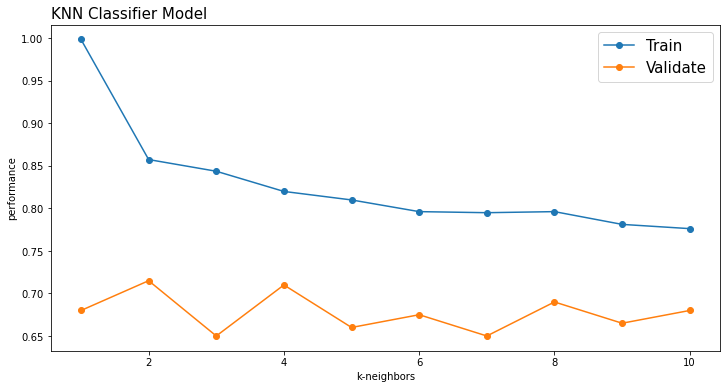

In [27]:
# plot differences

plt.figure(figsize=(12,6))
plt.plot(frame['k'], frame['train_acc'], marker='o', label='Train')
plt.plot(frame['k'], frame['valid_acc'], marker='o', label='Validate')
plt.xlabel('k-neighbors')
plt.ylabel('performance')
plt.title('KNN Classifier Model', fontsize = 15, loc='left')

plt.legend(prop={'size':15})
plt.show()

### K = 2

In [28]:
knn_k2 = KNeighborsClassifier(n_neighbors=2)

# fit the training set
knn_k2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

## Train/Test Accuracy

In [29]:
# predict test set
y_pred = knn_k2.predict(X_test)

In [30]:
y_pred

array(['High', 'High', 'High', 'Med', 'High', 'Med', 'Med', 'Med', 'Low',
       'High', 'Med', 'High', 'High', 'Low', 'Med', 'Low', 'Low', 'Low',
       'Low', 'High', 'Med', 'High', 'High', 'Low', 'Low', 'Low', 'High',
       'Low', 'Low', 'Low', 'Low', 'High', 'Low', 'Low', 'High', 'High',
       'Low', 'High', 'Low', 'Low', 'Med', 'Low', 'High', 'Med', 'Low',
       'Low', 'Low', 'High', 'Med', 'Low', 'Low', 'High', 'High', 'Low',
       'Med', 'Low', 'Low', 'Low', 'Med', 'High', 'Low', 'High', 'High',
       'Med', 'Low', 'High', 'High', 'Low', 'Low', 'High', 'Low', 'Low',
       'Low', 'Low', 'Low', 'Low', 'Low', 'High', 'Low', 'Low', 'High',
       'High', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'High', 'Low',
       'Low', 'High', 'Low', 'High', 'Low', 'Low', 'Low', 'Low', 'High',
       'Low', 'Low', 'Med', 'High', 'Low', 'Low', 'Low', 'High', 'Med',
       'Low', 'Low', 'Low', 'High', 'Low', 'High', 'Low', 'Low', 'Low',
       'High', 'Low', 'Low', 'Low', 'Low', 'High', 'Lo

In [31]:
# confusion matrix
conf_matrix_knn = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual high', 'actual low', 'actual med'], 
                               columns = ['predicted high', 'predicted low', 'predicted med'])

conf_matrix_knn

,predicted high,predicted low,predicted med
actual high,42,5,10
actual low,7,88,2
actual med,16,17,13


Accuracy:  the proportion of predictions that the model classified correctly.

In [33]:
# accuracy score
accuracy_score(y_test, y_pred)

0.715

Recall: The proportion of actual positives was identified correctly

In [55]:
# recall
recall_score(y_test, y_pred, average=None)

array([0.73684211, 0.90721649, 0.2826087 ])

Precision: the proportion of positive identifications was actually correct

In [54]:
# precision score
precision_score(y_test, y_pred, average=None)

array([0.64615385, 0.8       , 0.52      ])

### Confusion Matrix Visual

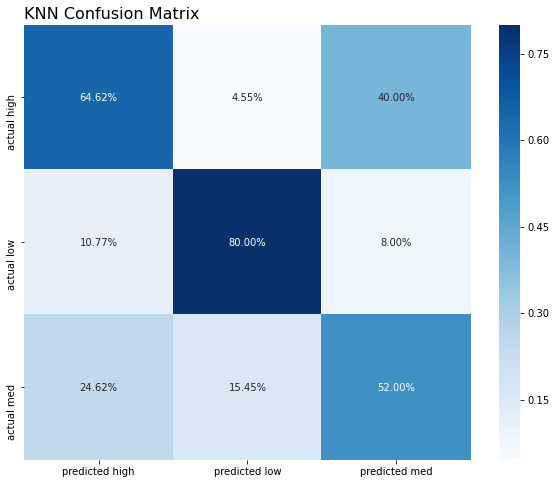

In [60]:
fig, ax = plt.subplots(figsize = (10,8))


sns.heatmap(conf_matrix_knn/np.sum(conf_matrix_knn), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('KNN Confusion Matrix', fontsize = 16, loc='left')

plt.show()

### Cross-Validation

In [34]:
# run KNN on different values of K
cv_scores_mean = []
for k in range(1,10):
    knn_model1_cv = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_model1_cv, X, y, cv=10)
    
    cv_scores_mean.append(np.mean(cv_scores))

In [35]:
cv_scores_mean

[0.70299399939994,
 0.7129145914591459,
 0.701964496449645,
 0.727975197519752,
 0.709974597459746,
 0.7109246924692469,
 0.715944694469447,
 0.7249248924892489,
 0.7249248924892489]

In [36]:
frame_cv = pd.DataFrame({'k':range(1,10), 'cv_score': cv_scores_mean})
frame_cv

,k,cv_score
0,1,0.702994
1,2,0.712915
2,3,0.701964
3,4,0.727975
4,5,0.709975
5,6,0.710925
6,7,0.715945
7,8,0.724925
8,9,0.724925


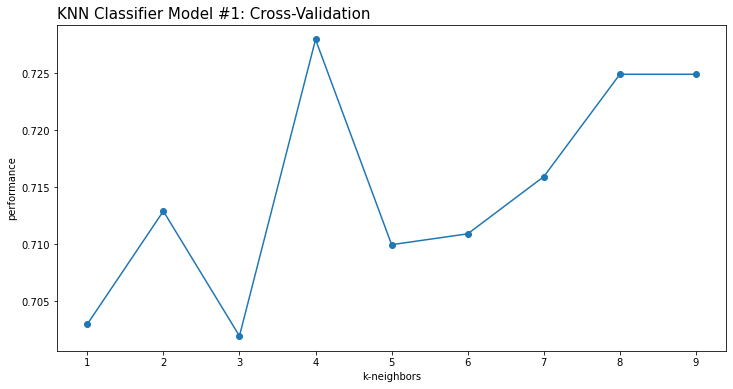

In [37]:
# plot cv scores

plt.figure(figsize=(12,6))
plt.plot(frame_cv['k'], frame_cv['cv_score'], marker='o')
plt.xlabel('k-neighbors')
plt.ylabel('performance')
plt.title('KNN Classifier Model #1: Cross-Validation', fontsize = 15, loc='left')

plt.show()

# Model # 2 : No Catalogs

In [38]:
# remove catalogs
no_catalogs = DirectMarketing_Cln_Labels.copy()
no_catalogs = no_catalogs.drop(['Catalogs'], axis=1)

In [39]:
# assign input data and target variable
X = no_catalogs.iloc[:,0:-1]
y = no_catalogs.iloc[:,-1]

### Optimal Values of K - Grid Search

In [40]:
# create grid search
knn_grid = GridSearchCV(estimator = KNeighborsClassifier(), 
                        param_grid={'n_neighbors': np.arange(1,20)}, cv=10)

In [41]:
# fit the model
knn_grid.fit(X,y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [42]:
# best params
knn_grid.best_params_

{'n_neighbors': 4}

### Train/Test

In [43]:
# split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [44]:
train_accuracy = []
validation_accuracy = []
for k in range(1,10):
    knn_model2 = KNeighborsClassifier(n_neighbors=k)
    knn_model2.fit(X_train, y_train)
    train_accuracy.append(knn_model2.score(X_train, y_train))
    validation_accuracy.append(knn_model2.score(X_test, y_test))

In [45]:
frame2 = pd.DataFrame({'k':range(1,10), 'train_acc':train_accuracy, 'valid_acc':validation_accuracy})
frame2

,k,train_acc,valid_acc
0,1,0.99500,0.580
1,2,0.84250,0.660
2,3,0.82625,0.640
3,4,0.80500,0.675
4,5,0.78875,0.625
5,6,0.79375,0.660
6,7,0.77625,0.640
7,8,0.76375,0.625
8,9,0.75875,0.645


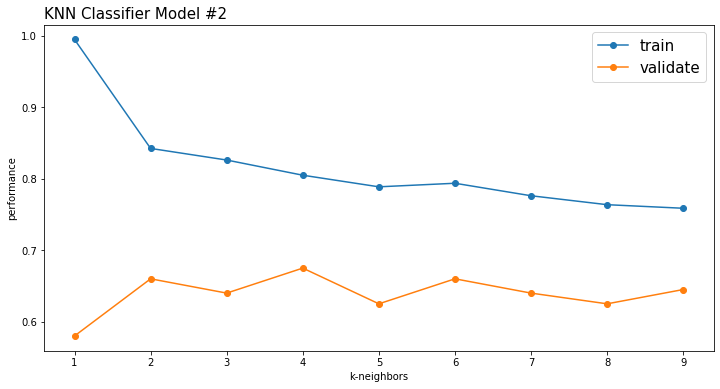

In [46]:
# plot differences

plt.figure(figsize=(12,6))
plt.plot(frame2['k'], frame2['train_acc'], marker='o', label='train')
plt.plot(frame2['k'], frame2['valid_acc'], marker='o', label='validate')
plt.xlabel('k-neighbors')
plt.ylabel('performance')
plt.title('KNN Classifier Model #2', fontsize = 15, loc='left')

plt.legend(prop={'size':15})
plt.show()

### Cross-Validation

In [47]:
# run KNN on different values of K
cv_scores_mean2 = []
for k in range(1,10):
    knn_model2_cv = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_model2_cv, X, y, cv=10)
    
    cv_scores_mean2.append(np.mean(cv_scores))

In [48]:
cv_scores_mean2

[0.65695299529953,
 0.6730031003100311,
 0.682032403240324,
 0.7099436943694369,
 0.70897399739974,
 0.7039438943894389,
 0.70195399539954,
 0.7029236923692369,
 0.703963896389639]

In [49]:
frame_cv2 = pd.DataFrame({'k':range(1,10), 'cv_score': cv_scores_mean2})
frame_cv2

,k,cv_score
0,1,0.656953
1,2,0.673003
2,3,0.682032
3,4,0.709944
4,5,0.708974
5,6,0.703944
6,7,0.701954
7,8,0.702924
8,9,0.703964


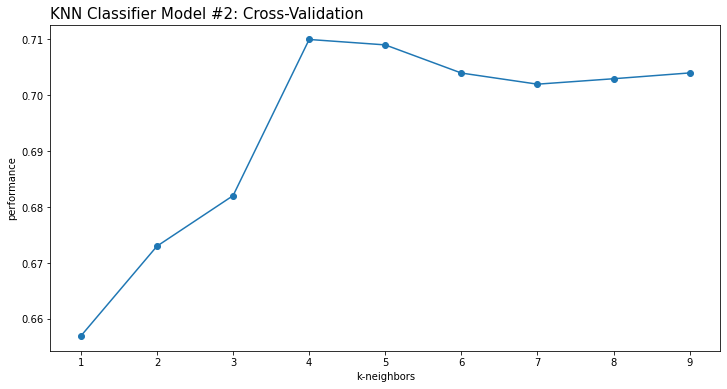

In [50]:
# plot cv scores

plt.figure(figsize=(12,6))
plt.plot(frame_cv2['k'], frame_cv2['cv_score'], marker='o')
plt.xlabel('k-neighbors')
plt.ylabel('performance')
plt.title('KNN Classifier Model #2: Cross-Validation', fontsize = 15, loc='left')

plt.show()